In [42]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss

from scipy import signal # Using scipy: Subtract the line of best fit
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time series intro

Any time series may be split into the following components: Base Level, Trend, Seasonality,Error

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative
	
		○ Additive time series:
		○ Value = Base Level + Trend + Seasonality + Error
	
		○ Multiplicative Time Series:
		○ Value = Base Level x Trend x Seasonality x Error


In [25]:
# Import as Dataframe
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


another way

In [26]:
ser = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
ser.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


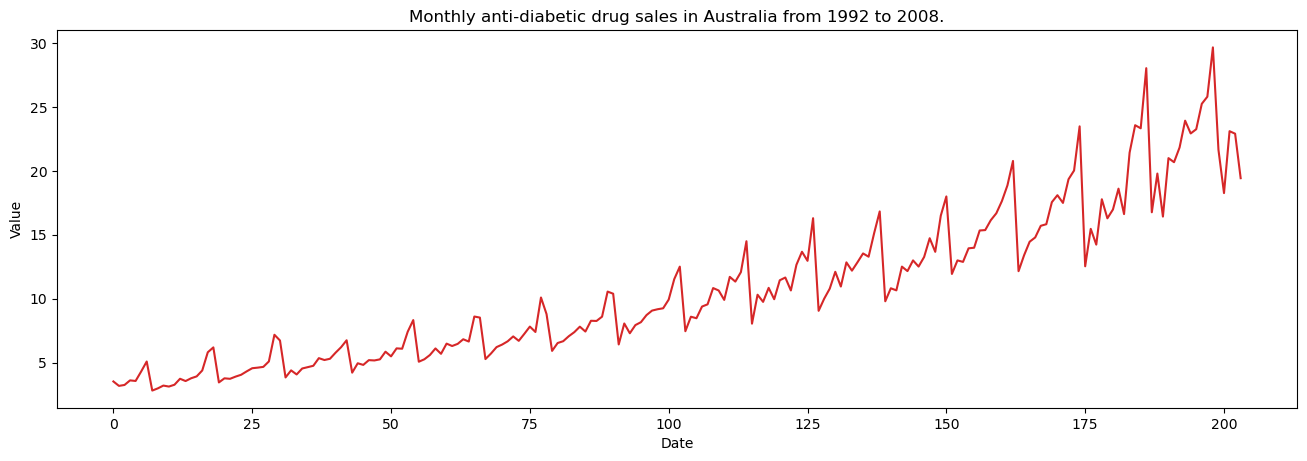

In [3]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')    

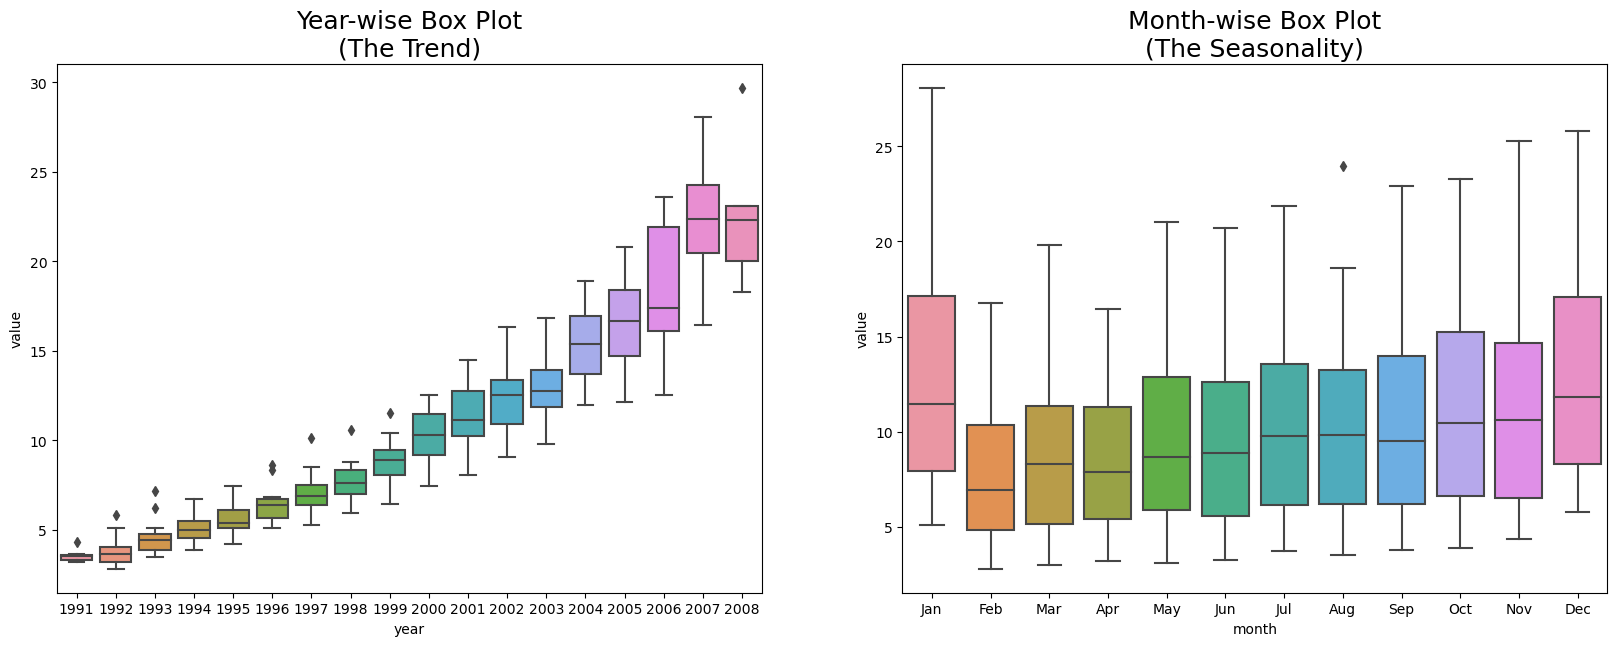

In [7]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 100)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :]) #~:inversing mask

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## How to decompose a time series into its components?

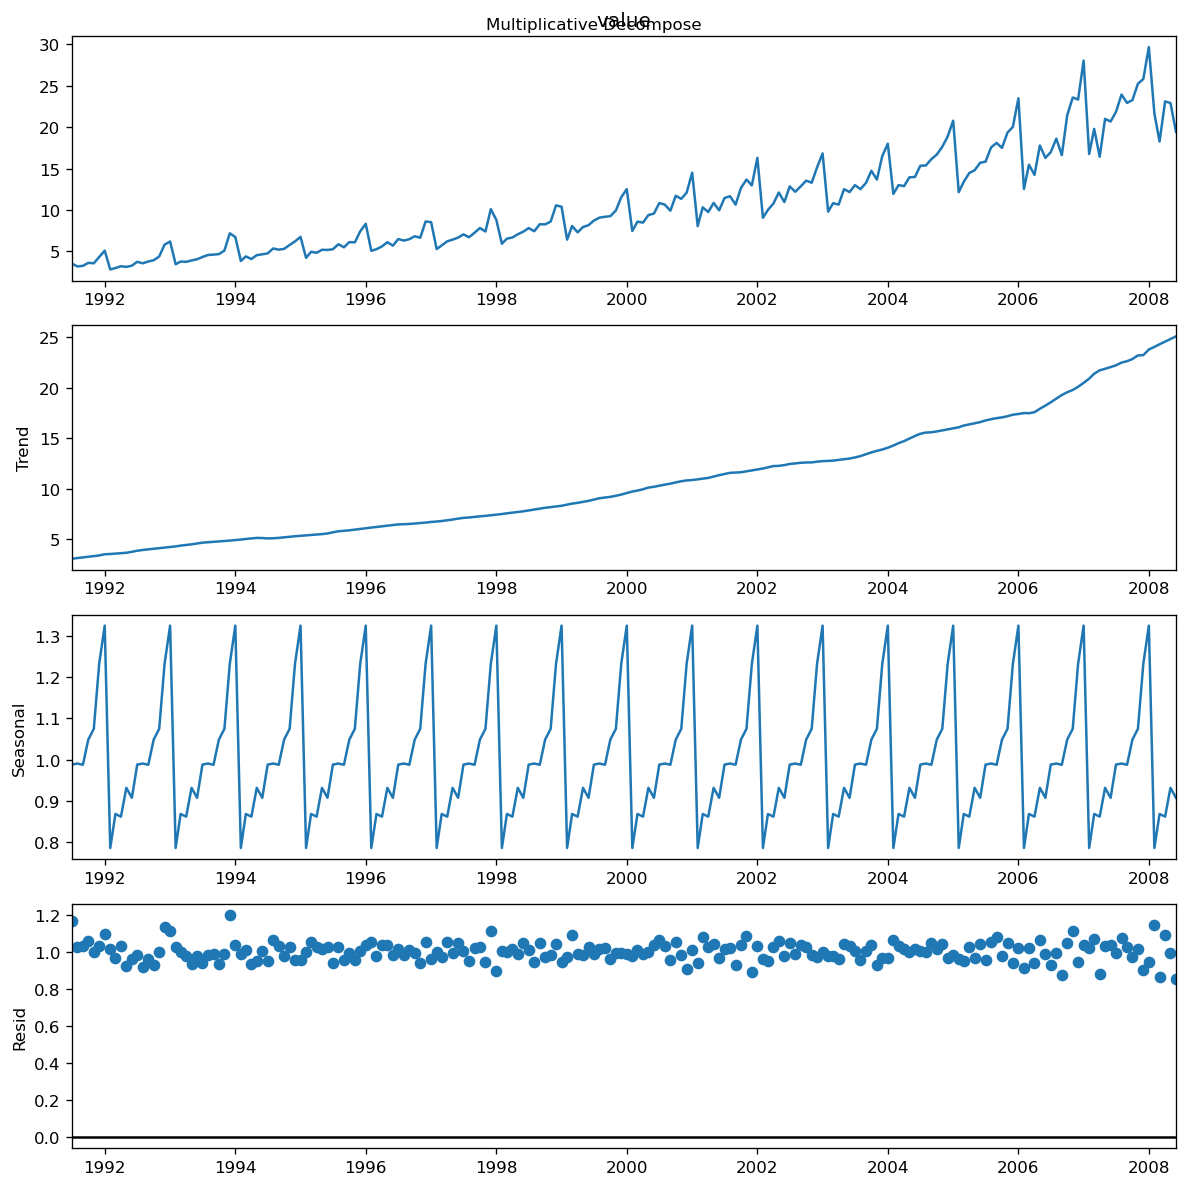

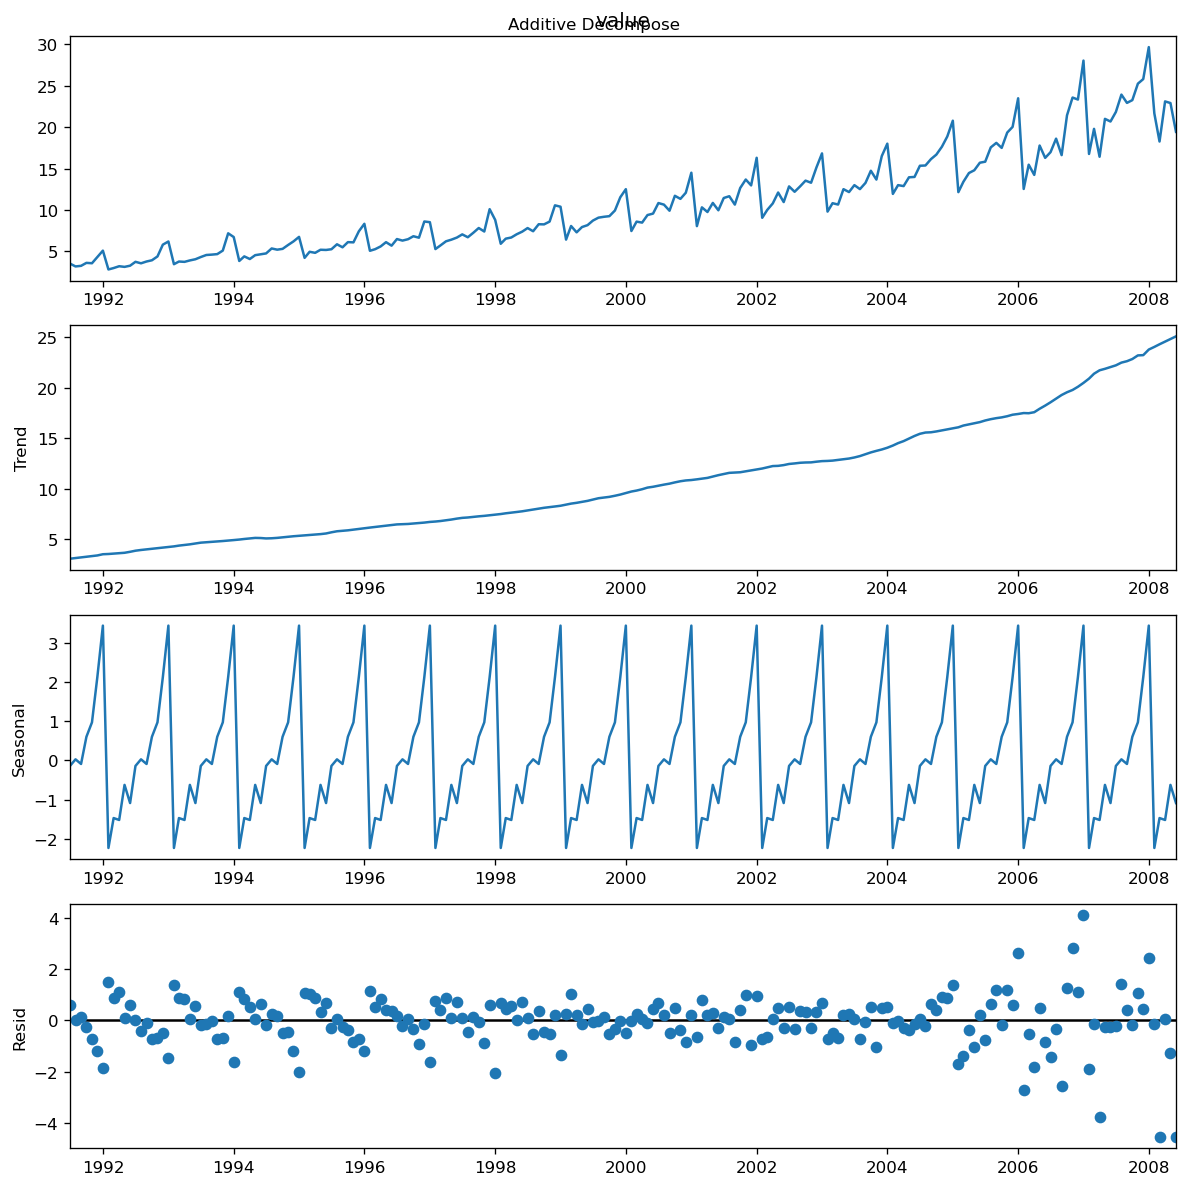

In [28]:
df_index = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_index['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_index['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.show()

If you look at the residuals of the additive decomposition closely, it has some pattern left over. The multiplicative decomposition, however, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.

In [18]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seasonality', 'trend', 'resident', 'actual_values']
df_reconstructed.head()

,seasonality,trend,resident,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


## how to identify if a series is stationary or not?

ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test.

In [29]:
# ADF Test
result = adfuller(df.value.values, autolag='AIC')
#autolag{“AIC”, “BIC”, “t-stat”, None} Method to use when automatically determining the lag length among the values 0, 1, …, maxlag.
#If “AIC” (default) or “BIC”, then the number of lags is chosen to minimize the corresponding information criterion.
#“t-stat” based choice of maxlag. Starts with maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.
#If None, then the number of included lags is set to maxlag.

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.1451856893067376
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476

KPSS Statistic: 1.313675
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/kkee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/kkee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## How to detrend a time series?

- Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.

- Subtract the trend component obtained from time series decomposition we saw earlier.

- Subtract the mean

- Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the least squares fit')

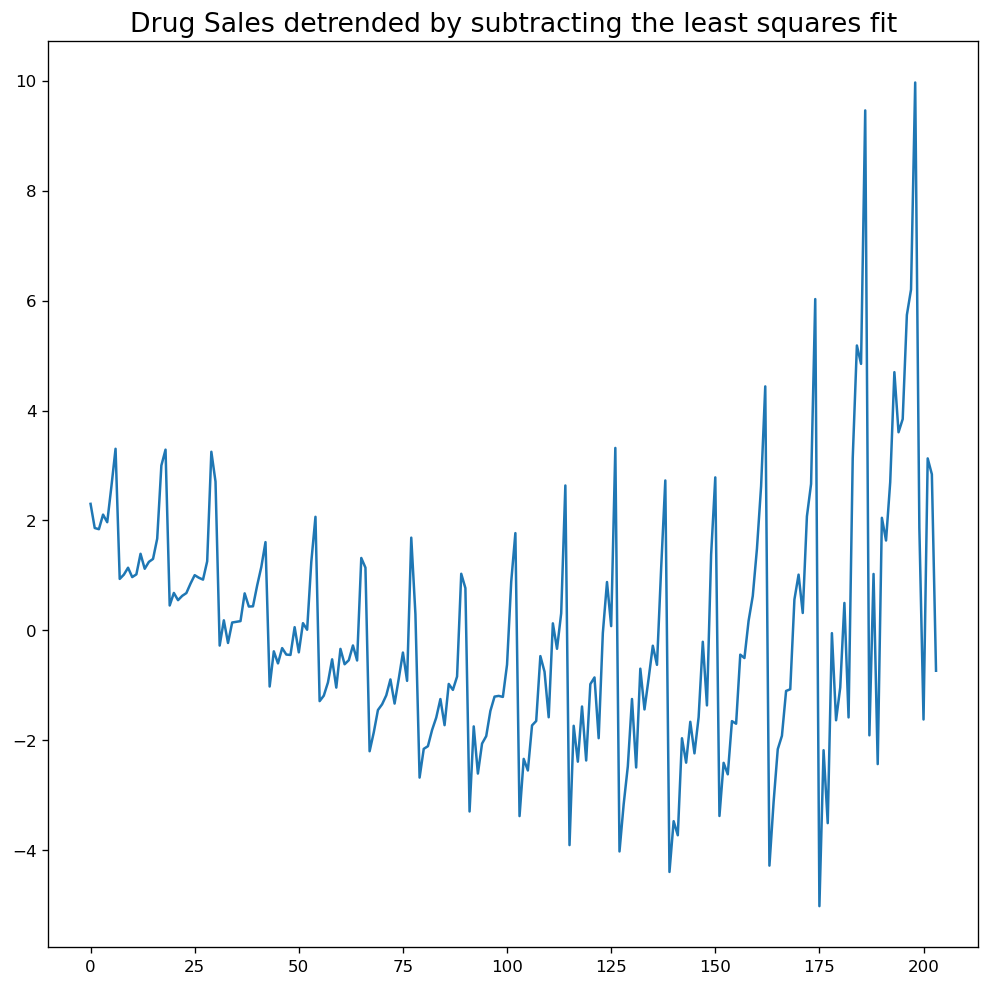

In [30]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
detrended = signal.detrend(df.value.values)

plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

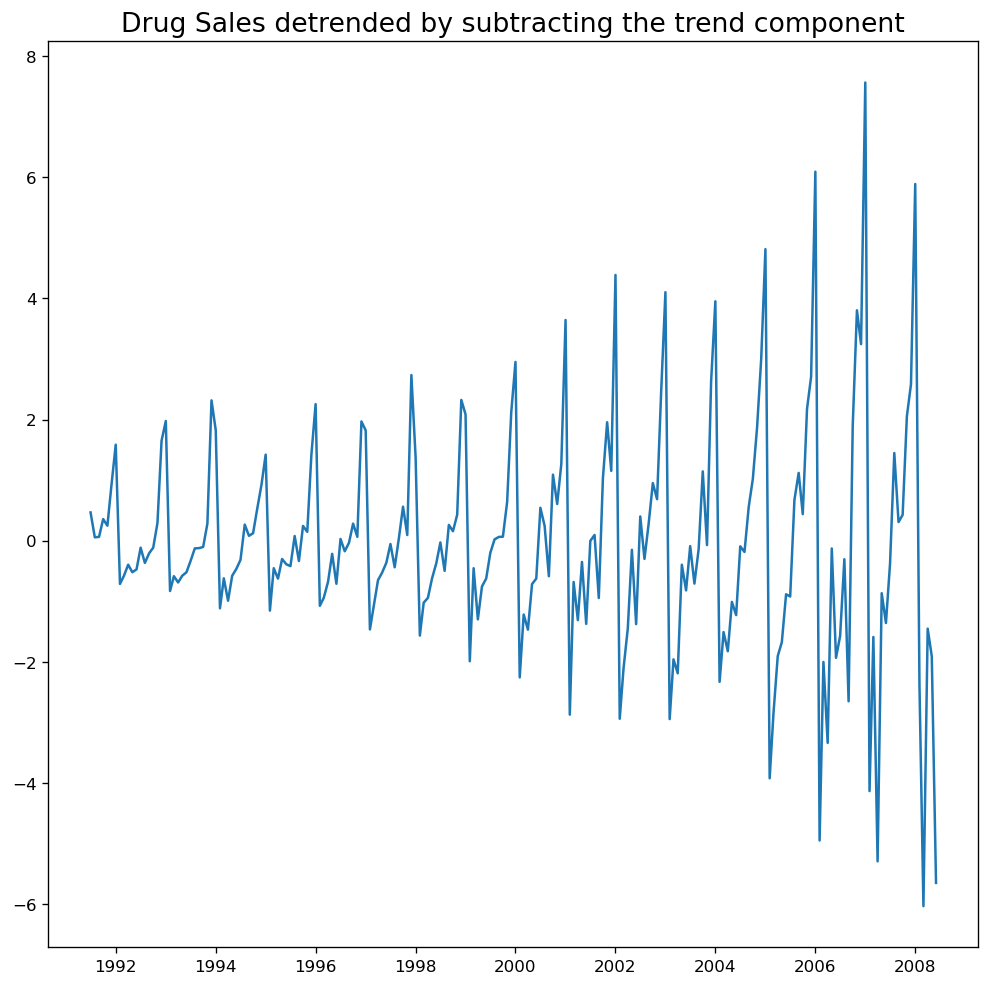

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

## How to deseasonalize a time series?

[]

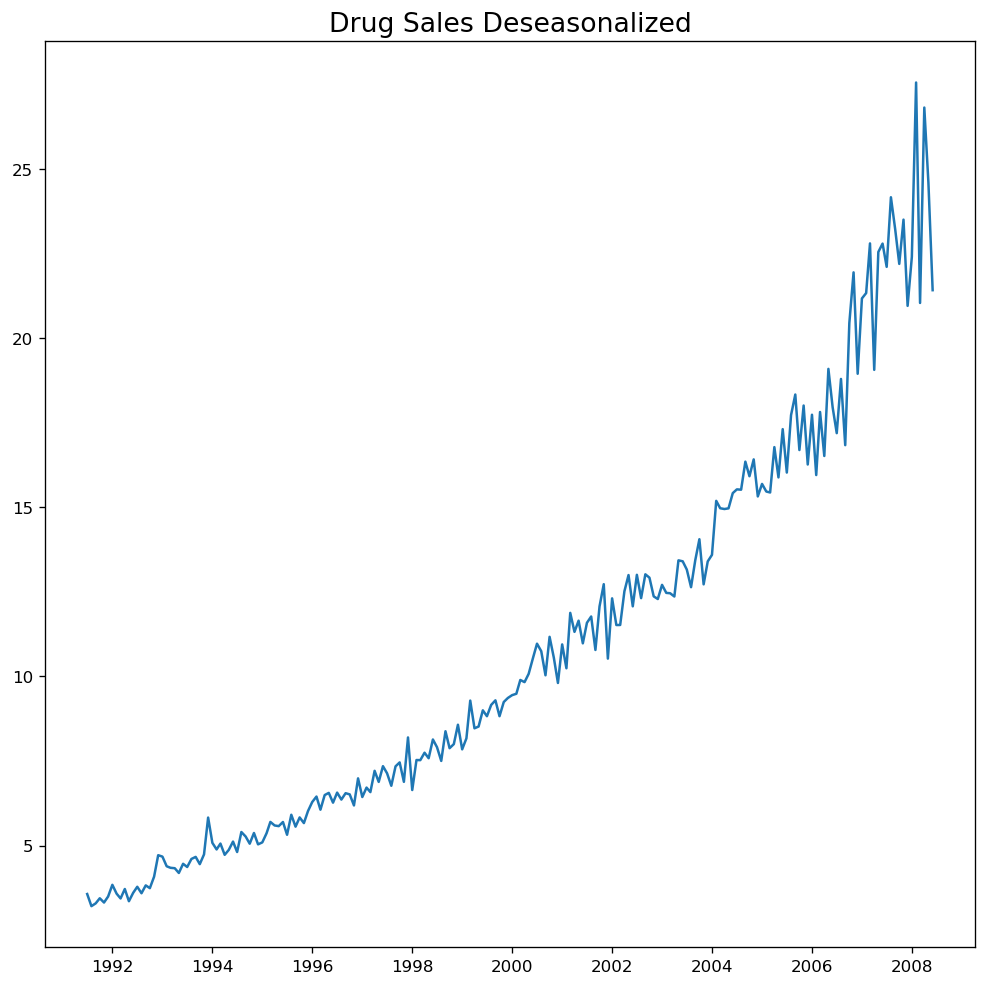

In [32]:
# Subtracting the Trend Component.

# Time Series Decomposition
result_mul = seasonal_decompose(df_index['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df_index.value.values / result_mul.seasonal  #因为是相乘所以去除影响就要相除

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

## How to test for seasonality of a time series?

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

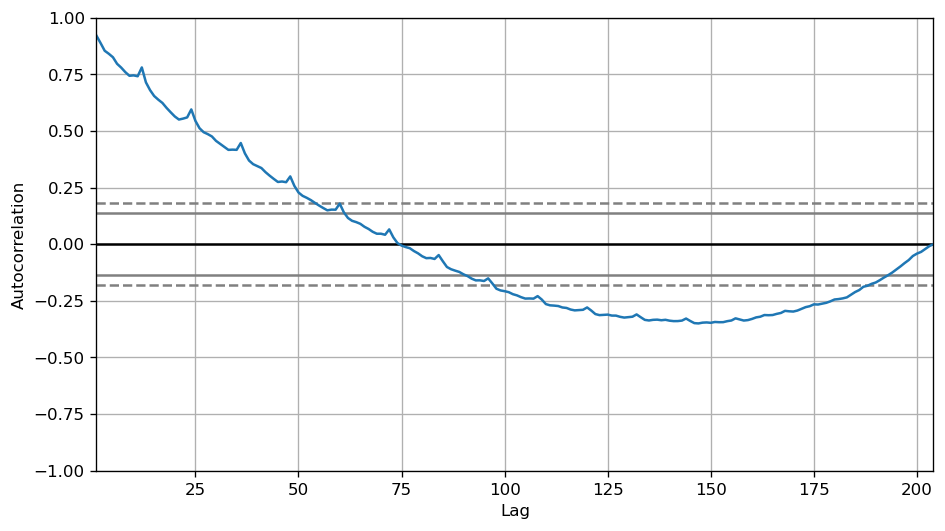

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())

## How to treat missing values in a time series?

ValueError: Found input variables with inconsistent numbers of samples: [100, 204]

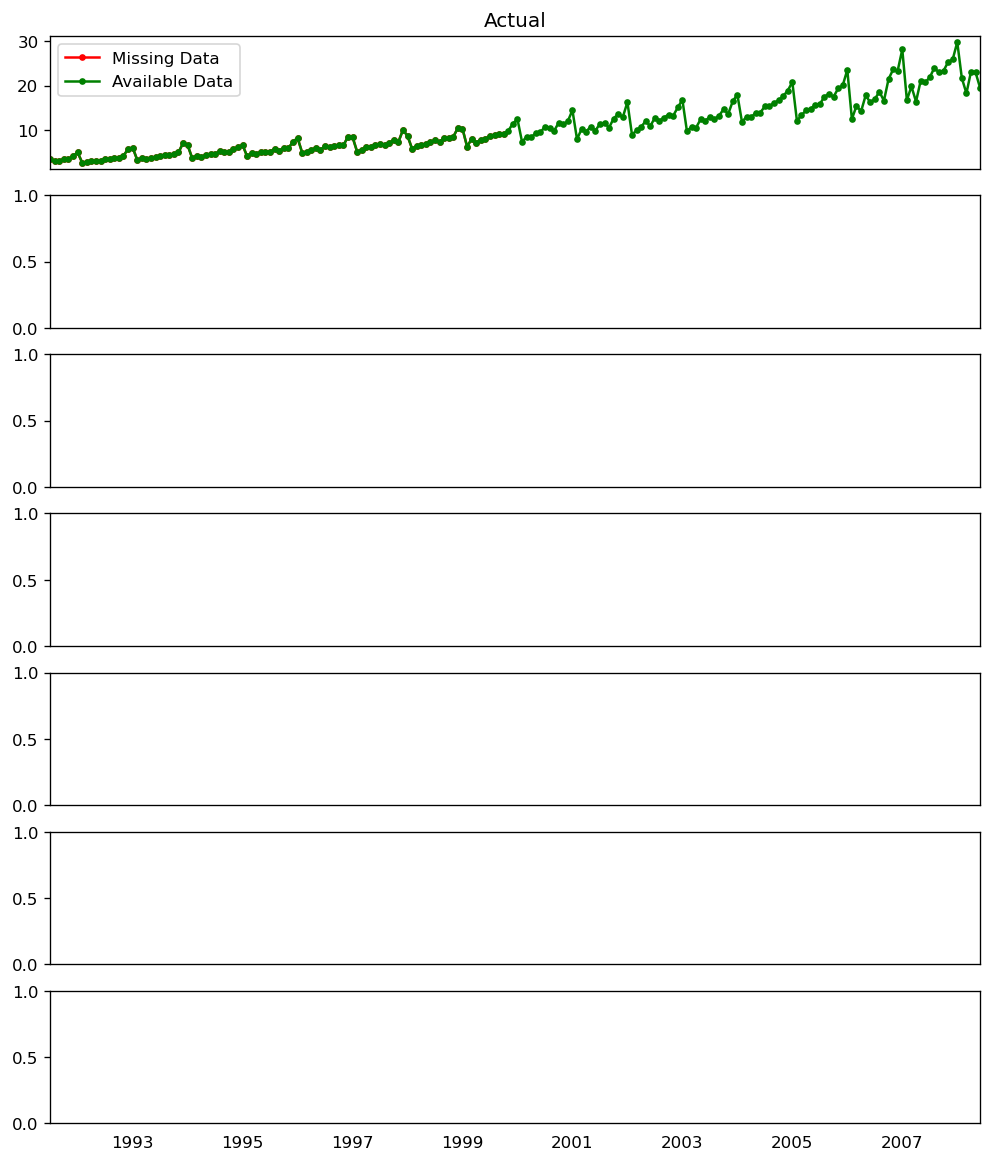

In [41]:
df_orig = df_index.head(100)
df = df_index

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])  #np.arange(3,7,2) -> array([3, 5])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum']) ## use interpolation function returned by `interp1d`
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")

## What is autocorrelation and partial autocorrelation functions?

/Users/kkee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


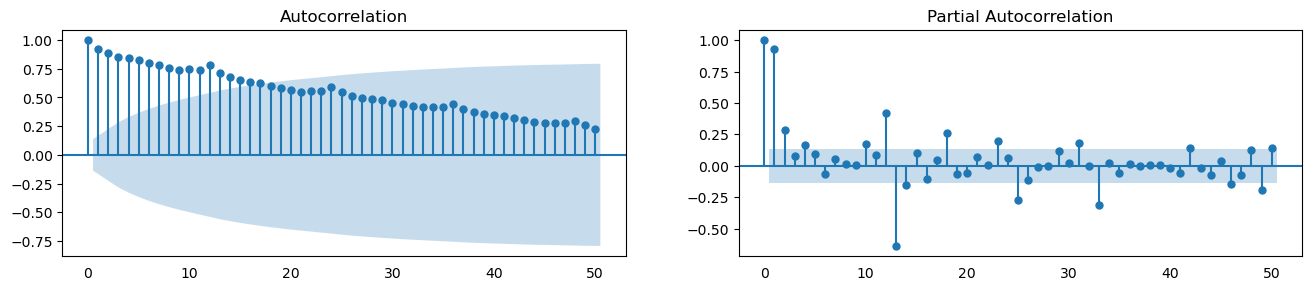

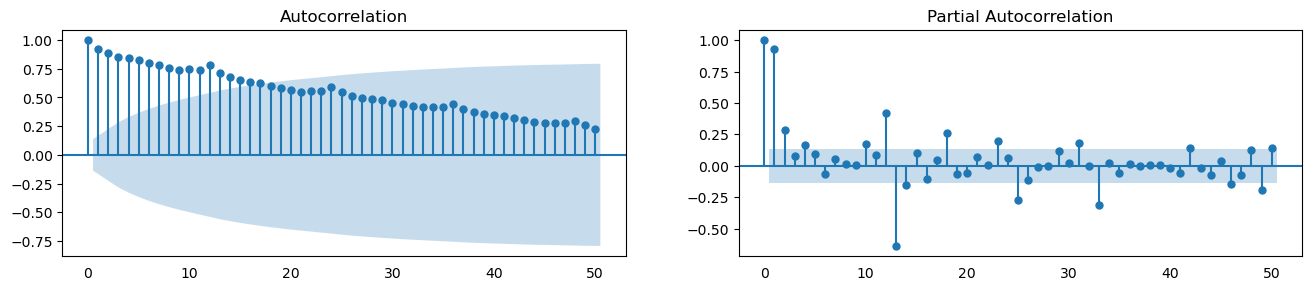

In [47]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(df.value, nlags=50)
pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

In [45]:
acf_50

array([1.        , 0.92056815, 0.88782519, 0.85385862, 0.84052841,
       0.82523769, 0.79629658, 0.77950157, 0.75953251, 0.74337588,
       0.74521347, 0.74134847, 0.78031252, 0.71424686, 0.68014097,
       0.65401657, 0.63791893, 0.62349882, 0.60171747, 0.58230335,
       0.5638103 , 0.5502367 , 0.55428812, 0.55963579, 0.5948865 ,
       0.5443742 , 0.5118496 , 0.49425977, 0.48585482, 0.47551253,
       0.45600656, 0.44259219, 0.42927946, 0.416305  , 0.4173017 ,
       0.41648248, 0.44663227, 0.40084543, 0.36925858, 0.35321116,
       0.34468629, 0.33615309, 0.31790639, 0.30248802, 0.2882186 ,
       0.27463544, 0.2766393 , 0.27364256, 0.29913888, 0.25730382,
       0.22818248])